In [106]:
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz as gv
import numbers
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [277]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        '''
            initialize a labeled set with input dimension and ordinal attributes definition
        '''
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
        
    
    #Renvoie la valeur de y_i
    def getY(self, i):
        return(self.y[i])

In [278]:
class F_layer:
    '''
        object-wise local monotonicity measure 
    '''

    def value(self, w_i, labeled_set, esa, esl):
        raise NotImplementedError
        
    def equal_sets_attribute(self, labeled_set, a_j):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its equal set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[a_j]
            dominant_sets[i] = np.unique(values[values[:,a_j] == v][:,labeled_set.getInputDimension()])

        return dominant_sets
    
    def equal_sets_label(self, labeled_set):    
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant_sets[i] = np.unique(values[values[:,0] == v][:,1])

        return dominant_sets
    
    def dominant_sets_attribute(self, labeled_set, a_j):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[a_j]
            dominant_sets[i] = np.unique(values[values[:,a_j] >= v][:,labeled_set.getInputDimension()])

        return dominant_sets

    def dominant_sets_label(self, labeled_set):
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant_sets[i] = np.unique(values[values[:,0] >= v][:,1])

        return dominant_sets
    
class F_layer_rank(F_layer):
    '''
        object-wise local monotonicity measure 
    '''

    def value(self, w_i, labeled_set, dsa, dsl, esa):
        raise NotImplementedError
        
class F_layer_non_rank(F_layer):
    '''
        object-wise local monotonicity measure 
    '''

    def value(self, w_i, labeled_set, esa, esl):
        raise NotImplementedError
        
class Ds(F_layer_non_rank):
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return ds value of w_i, a_j
        '''
        esa_i = esa[w_i]
        esl_i = esl[w_i]
        intersection = np.intersect1d(esa_i, esl_i)
        
        return intersection.size * 1.0 / esa_i.size
    
class Dsr(F_layer_rank):
    
    def value(self, w_i, labeled_set, dsa, dsl, esa):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return dsr value of w_i, a_j
        '''
        dsa_i = dsa[w_i]
        dsl_i = dsl[w_i]
        intersection = np.intersect1d(dsa_i, dsl_i)
        
        return intersection.size * 1.0 / dsa_i.size
    
class Minds(F_layer_non_rank):
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return minds value of w_i, a_j
        '''
        n = labeled_set.size()
        equal_set = esa[w_i]
        min_l = np.iinfo(np.int32).max
        
        for w_h in equal_set:
            l = (np.intersect1d(esa[w_h], esl[w_h]).size)
            if min_l > l:
                min_l = l
    
        return min_l * 1.0 / equal_set.size
    
class Mindsr(F_layer_rank):  
    def value(self, w_i, labeled_set, dsa, dsl, esa):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            dsa : dictionnary of dominant sets generated by a_j
            dsl : dictionnary of dominant sets generated by a_j
            esa : dictionnary of equal sets generated by a_j
            return mindsr value of w_i, a_j
        '''
        n = labeled_set.size()
        dominant_set = dsa[w_i]
        equal_set = esa[w_i]
        min_l = np.iinfo(np.int32).max
        
        for w_h in equal_set:
            l = np.intersect1d(dsa[w_h], dsl[w_h]).size
            if min_l > l:
                min_l = l
    
        return min_l * 1.0 / dominant_set.size

class Maxds(F_layer_non_rank):

    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            dsa : dictionnary of dominant sets generated by a_j
            dsl : dictionnary of dominant sets generated by a_j
            esa : dictionnary of equal sets generated by a_j
            return maxds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        equal_set = esa[w_i]
        max_l = np.iinfo(np.int32).min
        
        for w_h in equal_set:
            l = np.intersect1d(esa[w_h], esl[w_h]).size
            if max_l < l:
                max_l = l    
    
        return max_l * 1.0 / equal_set.size
    
class Maxdsr(F_layer_rank):
    def value(self, w_i, labeled_set, dsa, dsl, esa):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            dsa : dictionnary of dominant sets generated by a_j
            dsl : dictionnary of dominant sets generated by a_j
            esa : dictionnary of equal sets generated by a_j
            return maxdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        dominant_set = dsa[w_i]
        equal_set = esa[w_i]
        max_l = np.iinfo(np.int32).min
        
        for w_h in equal_set:
            l = np.intersect1d(dsa[w_h], dsl[w_h]).size
            if max_l < l:
                max_l = l    
    
        return max_l * 1.0 / dominant_set.size
    
class Avgds(F_layer_non_rank):
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return avgds value of w_i, a_j
        '''
        n = labeled_set.size()
        s = 0

        equal_set = esa[w_i]

        for w_h in equal_set:
            s += np.intersect1d(esa[w_h], esl[w_h]).size
            
        return ((1.0/equal_set.size)* s) / (1.0 * equal_set.size)
    
class Avgdsr(F_layer_rank):
    def value(self, w_i, labeled_set, dsa, dsl, esa):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            dsa : dictionnary of dominant sets generated by a_j
            dsl : dictionnary of dominant sets generated by a_j
            esa : dictionnary of equal sets generated by a_j
            return avgdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        s = 0

        dominant_set = dsa[w_i]
        equal_set = esa[w_i]

        for w_h in equal_set:
            s += np.intersect1d(dsa[w_h], dsl[w_h]).size
            
        return ((1.0/equal_set.size) * s) / (dominant_set.size * 1.0)

In [279]:
class G_layer:
    '''
        object-wise local non-monotonicity measure
    '''
        
    def value(self, f_value):
        raise NotImplementedError
        
class Log(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return -log_2(f_value)
        '''
        return -log(f_value, 2) 
    
class One_minus(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return 1 - f_value
        '''
        return 1 - f_value

In [280]:
class H_layer:
    '''
        aggregated local non-monotonicity measure
    '''
        
    def value(self, g_values, labeled_set):
        raise NotImplementedError
        
class Sum(H_layer):    
    def value(self, g_values, labeled_set):
        '''
            return (1/labeled_set.size()) * sum(g_values)
        '''
        return (1.0/labeled_set.size()) * np.sum(g_values)

In [281]:
class Gdm:
    '''
        Generic rank discrimination measure
    '''
    def __init__(self, h, g, f):
        '''
            h : object-wise local monotonicity measure 
            g : object-wise local non-monotonicity measure 
            f : aggregated local non-monotonicity measure
            labeled_set : labeled set
        '''
        self.h = h 
        self.g = g
        self.f = f
    
    def value(self, labeled_set, a_j, dsa, dsl, esa, esl):
        g_f = []

        if (isinstance(self.f, F_layer_rank)):
            for i in range(0, labeled_set.size()):
                g_f.append(self.g.value(self.f.value(i, labeled_set, dsa, dsl, esa)))
        else:
            for i in range(0, labeled_set.size()):
                g_f.append(self.g.value(self.f.value(i, labeled_set, esa, esl)))
        
        return self.h.value(g_f, labeled_set)

In [282]:
def discretize(H, labeled_set, a_j):
    '''
        H : discrimation measure
        labeled_set : labeled set
        a_j : attribute to discretize
        return threshold which minimizes the entropy function H for given feature a_j, 
            along with minimum entropy value
    '''
    
    n = labeled_set.size()
    ind = np.argsort(labeled_set.x,axis=0)[:,a_j] # sort values according to attribute a_j
    
    # binary set : for each object w_i taken in ascending order of a_j value,
    # a_j(w_h) = 0 if a_j(w_h) <= a_j(w_i), 1 otherwise
    binary_set = LabeledSet(labeled_set.getInputDimension())
    binary_set.nb_examples = labeled_set.size()
    binary_set.x = labeled_set.x.copy()
    binary_set.x[:,a_j] = np.ones(labeled_set.size())
    binary_set.y = labeled_set.y
    
    thresholds = []
    H_values = []
    
    dsa = H.f.dominant_sets_attribute(binary_set, a_j)
    dsl = H.f.dominant_sets_label(binary_set)
    esa = H.f.equal_sets_attribute(binary_set, a_j)
    esl = H.f.equal_sets_label(binary_set)
    
    for i in range(n-1):
        current = labeled_set.getX(ind[i])[a_j]
        current_label = labeled_set.getY(ind[i])
        lookahead = labeled_set.getX(ind[i+1])[a_j]
        lookahead_label = labeled_set.getY(ind[i+1])
        binary_set.x[ind[i]][a_j] = 0
        
        for j in range(i+1, n-1):
            dsa[ind[j]] = np.delete(dsa[ind[j]], np.argwhere(dsa[ind[j]] == ind[i]))
            esa[ind[j]] = np.delete(esa[ind[j]], np.argwhere(esa[ind[j]] == ind[i]))
        
        if current == lookahead or current_label == lookahead_label:
            continue

        thresholds.append((current + lookahead) / 2.0)
        H_values.append(H.value(binary_set, a_j, dsa, dsl, esa, esl))
        
    min_entropy = min(H_values)
    min_threshold = thresholds[np.argmin(H_values)]
    
    return (min_threshold, min_entropy)

In [283]:
def majority_class(labeled_set, labels):
    '''
        labeled_set : labeled set
        label : list of labels
        return majority class in labeled_set
    '''
    classes_size = []
    
    for label in labels:
        classes_size.append(len(labeled_set.x[np.where(labeled_set.y == label),:][0]))

    return labels[np.argmax(np.array(classes_size))]

def constant_lambda(labeled_set):
    '''
        labeled_set : labeled set
        return true if all objects in labeled_set share the same label, false otherwise
    '''
    labels = labeled_set.y
    return np.all(labels == labels[0,:], axis=0)[0]

def shannon(P):
    Hs = 0
    k = len(P)
    for p_i in P:
        tmp = 0
        if p_i != 0:
            tmp = p_i * log(p_i, k)
        Hs += tmp
    
    return -Hs

def entropy(labeledSet, labels, name):
    P = []
    # get class distribution
    for label in labels:
        P.append(len(labeledSet.x[np.where(labeledSet.y == label),0:labeledSet.getInputDimension()][0]) / (1.0 * labeledSet.size()))
    
    # shannon entropy
    return shannon(P)

In [284]:
def divide(Lset, att, threshold):
    '''
        Lset : labeled_set
        att : index of attribute to divide
        threshold : threshold value
        divide Lset into two sub-sets : one with values for att <= threshold, one with values > threshold
    '''
    E1 = LabeledSet(Lset.getInputDimension())
    E2 = LabeledSet(Lset.getInputDimension())
    
    # Separate data according to threshold
    for i in range(Lset.size()):
        if Lset.getX(i)[att] <= threshold:
            E1.addExample(Lset.getX(i), Lset.getY(i))
        else:
            E2.addExample(Lset.getX(i), Lset.getY(i))
    
    return E1, E2

In [305]:
class BinaryTree:
    '''
        Binary tree
        deal with numeric attributes (ordinal attributes have to be pre-treated and must be orderable)
        deal with multi-class classification (classes must be orderable)
    '''
    def __init__(self):
        self.attribute = None
        self.label = None
        
        # binary tree
        self.threshold = None
        self.inf = None
        self.sup = None
        
    def isLeaf(self):
        """ 
            return True if tree is a leaf
        """
        return self.attribute == None
    
    def add_children(self, inf, sup, att, threshold):
        """
            inf, sup : trees
            att : index of attribute
            threshold : threshold value
            add children to node
        """
        self.attribute = att
        self.threshold = threshold
        self.inf = inf
        self.sup = sup
    
    def addLeaf(self,label):
        """ 
            add leaf corresponding to label
        """
        self.label = label
        
    def classify(self,example):
        """ 
            example : numpy array in labeled set
            classify example
        """
        if self.isLeaf():
            return self.label
        else:
            if example[self.attribute] <= self.threshold:
                return self.inf.classify(example)
            return self.sup.classify(example)
                
    def to_graph(self, g, prefix='A'):
        """ 
            build a representation of the tree
        """
        if self.isLeaf():
            g.node(prefix,str(self.label),shape='box')
        else:
            g.node(prefix, str(self.attribute))
            
            g.node(prefix, str(self.attribute))
            self.inf.to_graph(g,prefix+"l")
            self.sup.to_graph(g,prefix+"r")
            g.edge(prefix,prefix+"l", '<='+ str(self.threshold))
            g.edge(prefix,prefix+"r", '>'+ str(self.threshold))
        return g
    
    def get_depth(self):
        if self.isLeaf():
            return 1
        else:
            return 1 + max(self.inf.get_depth(), self.sup.get_depth())


In [286]:
def build_DT(labeled_set, H, H_stop, measureThreshold, maxDepth, percMinSize, labels, current_depth):
    '''
        labeled_set : labeled set
        H : rank discrimination measure used for discretization
        H_stop : discrimination measure (shannon, gini ...) used for stopping condition
        measure_threshold : lower bound for H_stop
        max_depth : maximum length of a path from the root to a leaf node
        percMinSize : minimum size of the current object set labeled_set
        build decision tree recursively
    '''
    
    h = entropy(labeled_set, labels, "shannon")
    
    if (h < measureThreshold) or (labeled_set.size() < percMinSize) or (constant_lambda(labeled_set)) or (current_depth > maxDepth):
        leaf = BinaryTree()
        leaf.addLeaf(majority_class(labeled_set, labels))
        return leaf
    
    
    m = labeled_set.getInputDimension()
    min_threshold = None
    min_attribute = None
    
    h_values = []
    thresholds = []
    
    for a_j in range(m):
        # numeric attribute
        threshold, h = discretize(H, labeled_set, a_j)
        thresholds.append(threshold)
        h_values.append(h)
        
    min_threshold = thresholds[np.argmin(h_values)]
    min_attribute = np.argmin(h_values)
    
    inf_set, sup_set = divide(labeled_set, min_attribute, min_threshold)
    bt = BinaryTree()
    
    if inf_set.size() == 0:
        bt.addLeaf(majority_class(sup_set), labels)
        return bt
    if sup_set.size() == 0:
        bt.addLeaf(majority_class(inf_set), labels)
        return bt
    
    inf_bt = build_DT(inf_set, H, H_stop, measureThreshold, maxDepth, percMinSize, labels, current_depth+1)
    sup_bt = build_DT(sup_set, H, H_stop, measureThreshold, maxDepth, percMinSize, labels, current_depth+1)
    bt.add_children(inf_bt, sup_bt, min_attribute, min_threshold)
    return bt

In [287]:
class Classifier:
    def __init__(self,input_dimension):
        raise NotImplementedError("Please Implement this method")
    
    def predict(self,x):
        '''
            x : example
            compute prediction on x => return score
        '''
        raise NotImplementedError("Please Implement this method")

    def train(self,labeled_set):
        '''
            labeled_set : labeled set
            train model on labeled_set
        '''
        raise NotImplementedError("Please Implement this method")
    
    def accuracy(self,set):
        '''
            set : labeled_set
            return accuracy score on whole dataset
        '''
        nb_ok=0
        for i in range(set.size()):
            score = self.predict(set.getX(i))
            if (score*set.getY(i)>0):
                nb_ok = nb_ok+1
        acc = nb_ok/(set.size() * 1.0)
        return acc    
    
def plot_frontiere(set,classifier,step=10):
    """ LabeledSet * Classifier * int -> NoneType
        display decision boundary associated with classifier
    """
    mmax=set.x.max(0)
    mmin=set.x.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # compute prediction on each point of the grid
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # plot boundaries
    plt.contourf(x1grid,x2grid,res,colors=["red","cyan"],levels=[-1000,0,1000],linewidth=2)


In [288]:
class RDMT(Classifier):
    '''
        Rank discrimination measure tree 
    '''
    def __init__(self, H, H_stop, measureThreshold, maxDepth, percMinSize, labels):
        '''
            H : discrimination measure to minimize for splitting
            H_stop : discrimination measure (shannon, gini ...) used for stopping condition
            measureThreshold : lower bound for the discrimination measure H
            maxDepth : maximum length of a path from the root to a leaf node
            percMinSize : minimum size of the current object set 
            labels : list of classes
        '''
        self.H = H
        self.H_stop = H_stop
        self.measureThreshold = measureThreshold
        self.maxDepth = maxDepth
        self.percMinSize = percMinSize
        self.labels = labels
        self.root = None
        
    def predict(self,x):
        '''
            classify x using RDMT
            return prediction
        '''
        label = self.root.classify(x)
        return label
    
    def train(self,set):
        '''
            set : training set
            builds RDMT using set
        '''
        self.set = set
        self.root = build_DT(set,self.H, self.H_stop, self.measureThreshold, self.maxDepth, self.percMinSize, self.labels, 0)
    
    def plot(self):
        '''
            display tree
        '''
        gtree = gv.Digraph(format='png')
        return self.root.to_graph(gtree)        

In [289]:
def generate_2Ddataset(a_j, k, n, noise, amplitude, ranges):
    '''
        a_j : monotone attribute
        k : number of labels
        n : number of examples to create 
        noise :  % of non-monotone noise
        amplitude : amplitude of noise
        ranges : array of arrays indicating, for each attribute, its min and max values
        return 2D dataset containing k classes and n examples, with a_j being the monotone attribute
    '''
    labeled_set = LabeledSet(2)
    p = round(n/k)
    r = n # remaining examples to add 
    
    current_min = ranges[a_j][0]
    total_range = ranges[a_j][1] - ranges[a_j][0]
    
    thresholds = []
    
    for q in range(k):
        current_max = current_min + (total_range / k) 

        if (current_max > ranges[a_j][1]):
            current_max = ranges[a_j][1]
        
        if (current_max < ranges[a_j][1] and q == k-1):
            current_max = ranges[a_j][1] 
        
        
        if (p < r) and (q==k-1):
            p = r

        
        monotone_values = np.random.uniform(current_min, current_max, size=(p,1))
        
        if noise > 0:
            sample_size = np.random.binomial(len(monotone_values), noise)
            sample = np.random.randint(0, len(monotone_values), size=sample_size)
            
            for e in sample:
                if random.random() < 0.5:
                    val = current_min - random.uniform(0, total_range * amplitude)
                    if (val < ranges[a_j][0]):
                        val = ranges[a_j][0]
                    monotone_values[e] = val
                else:
                    val = current_max + random.uniform(0, total_range * amplitude)
                    if (val > ranges[a_j][1]):
                        val = ranges[a_j][1]
                    monotone_values[e] = val
        
        thresholds.append((current_min,current_max) )
        
        if (a_j == 0):
            random_values = np.random.uniform(ranges[1][0], ranges[1][1], size=(p, 1))
            values = np.hstack((monotone_values, random_values))
        else:
            random_values = np.random.uniform(ranges[0][0], ranges[0][1], size=(p,1))
            values = np.hstack((random_values, monotone_values))
        
        for i in range(p):
            labeled_set.addExample(values[i], q+1)
            
        current_min = current_max
        r -= p 
    return labeled_set, thresholds

In [290]:
def plot2DSet(labeled_set, title):
    labels = list(set([item for sublist in labeled_set.y.tolist() for item in sublist]))
    mark_dict = {
        ".":"point",
        ",":"pixel",
        "o":"circle",
        "v":"triangle_down",
        "^":"triangle_up",
        "<":"triangle_left",
        ">":"triangle_right",
        "1":"tri_down",
        "2":"tri_up",
        "3":"tri_left",
        "4":"tri_right",
        "8":"octagon",
        "s":"square",
        "p":"pentagon",
        "*":"star",
        "h":"hexagon1",
        "H":"hexagon2",
        "+":"plus",
        "D":"diamond",
        "d":"thin_diamond",
        "|":"vline",
        "_":"hline"
    }    
    S = []
    for label in labels:
        S.append(labeled_set.x[np.where(labeled_set.y == label),:][0])
    for i in range(len(labels)):
        plt.scatter(S[i][:,0],S[i][:,1],marker=list(mark_dict)[i])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)

In [291]:
def display_discretization(labeled_set, threshold, a_j, title):
    '''
        labeled_set : labeled_set
        threshold : value of threshold 
        a_j : index of discretized attribute
        title : plot title
        
        display 2D database along with threshold generated by discretization on attribute a_j
    '''
    plot2DSet(labeled_set, title)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold, threshold], [min_v, max_v])
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold, threshold])

    plt.show() 

In [292]:
def display_discretizations_comparison(labeled_set, threshold1, threshold2, real_thresholds, a_j, title, l1, l2):
    '''
        labeled_set : labeled_set
        threshold1 : threshold generated by discretization on a_j with first measure
        threshold2 : threshold generated by discretization on a_j with second measure
        real_thresholds : list of real thresholds
        title : plot title
        l1 : label of threshold1 (discrimination measure name)
        l2 : label of threshold2 (discrimination measure name)
        plot thresholds generated by two different discrimination measures on attribute a_j of labeled_set
    '''
    plot2DSet(labeled_set, title)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold1, threshold1], [min_v, max_v], color='green', label=l1)
        plt.plot([threshold2, threshold2], [min_v, max_v], color='red', label=l2)
        for i in range(len(real_thresholds)):
            threshold = real_thresholds[i]
            if i == 0:
                plt.plot([threshold, threshold], [min_v, max_v], color='black', label="real threshold")
            else:
                plt.plot([threshold, threshold], [min_v, max_v], color='black')
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold1, threshold1], color='green', label=l1)
        plt.plot([min_v, max_v], [threshold2, threshold2], color='red', label=l2)
        for i in range(len(real_thresholds)):
            threshold = real_thresholds[i]
            if i == 0:
                plt.plot([min_v, max_v], [threshold, threshold], color='black', label="real threshold")
            else:
                plt.plot([min_v, max_v], [threshold, threshold], color='black')
    plt.legend()
    plt.show() 

# Expérimentations sur des datasets jouets

On compare les arbres de décision crées par la rank shannon discrimination measure à ceux crées par l'entropie conditionnelle de Shannon.

In [293]:
g = Log()
h = Sum()

f_r = Dsr()
rsdm = Gdm(h, g, f_r)

f = Ds()
sdm = Gdm(h, g, f)

### 2 classes :

- 10 exemples : 

-> pas de bruit :

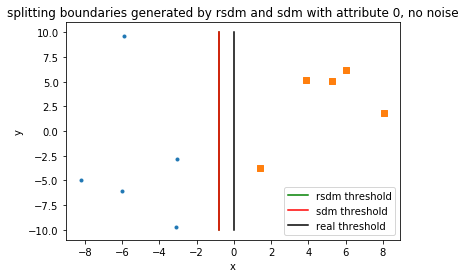

In [251]:
set2_10_0, t = generate_2Ddataset(0, 2, 10, 0., 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_10_0, 0)
t2, h2 = discretize(sdm, set2_10_0, 0)
display_discretizations_comparison(set2_10_0, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, no noise", "rsdm threshold", "sdm threshold")

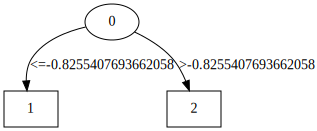

In [252]:
rdmt2_10 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_10.train(set2_10_0)
rdmt2_10.plot()

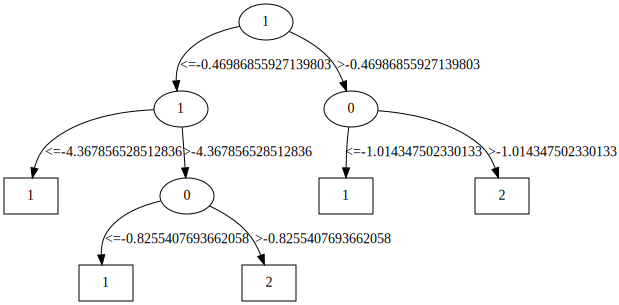

In [253]:
dmt2_10 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_10.train(set2_10_0)
dmt2_10.plot()

-> 30% de bruit :

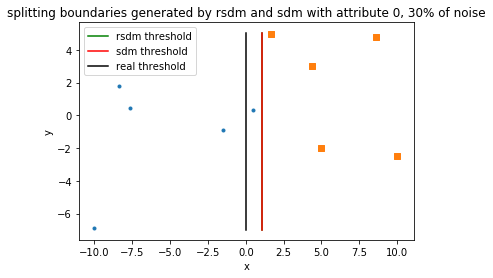

In [254]:
set2_10_30, t = generate_2Ddataset(0, 2, 10, 0.3, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_10_30, 0)
t2, h2 = discretize(sdm, set2_10_30, 0)
display_discretizations_comparison(set2_10_30, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 30% of noise", "rsdm threshold", "sdm threshold")

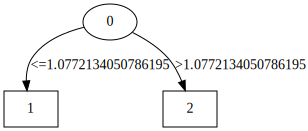

In [255]:
rdmt2_10 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_10.train(set2_10_30)
rdmt2_10.plot()

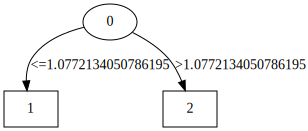

In [256]:
dmt2_10 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_10.train(set2_10_30)
dmt2_10.plot()

-> 70% de bruit :

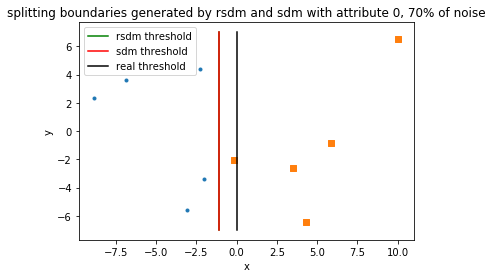

In [257]:
set2_10_70, t = generate_2Ddataset(0, 2, 10, 0.7, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_10_70, 0)
t2, h2 = discretize(sdm, set2_10_70, 0)
display_discretizations_comparison(set2_10_70, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 70% of noise", "rsdm threshold", "sdm threshold")

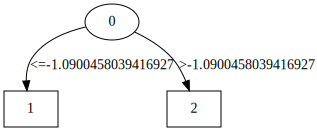

In [258]:
rdmt2_10 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_10.train(set2_10_70)
rdmt2_10.plot()

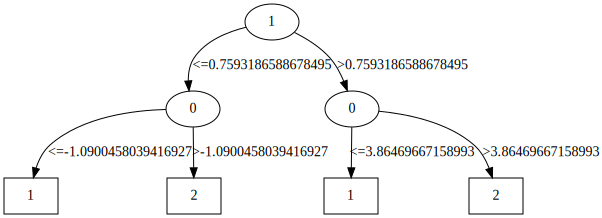

In [259]:
dmt2_10 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_10.train(set2_10_70)
dmt2_10.plot()

- 100 exemples :  

    -> pas de bruit :

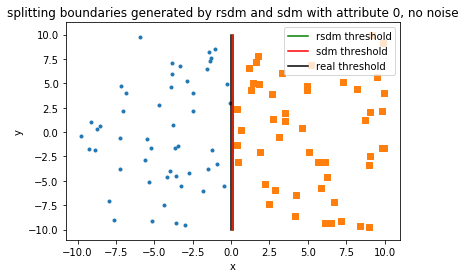

In [260]:
set2_100_0, t = generate_2Ddataset(0, 2, 100, 0., 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_100_0, 0)
t2, h2 = discretize(sdm, set2_100_0, 0)
display_discretizations_comparison(set2_100_0, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, no noise", "rsdm threshold", "sdm threshold")

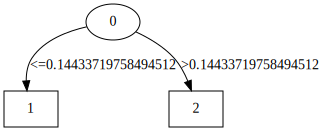

In [261]:
rdmt2_100 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_100.train(set2_100_0)
rdmt2_100.plot()

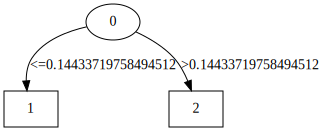

In [262]:
dmt2_100 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_100.train(set2_100_0)
dmt2_100.plot()

-> 30% de bruit :

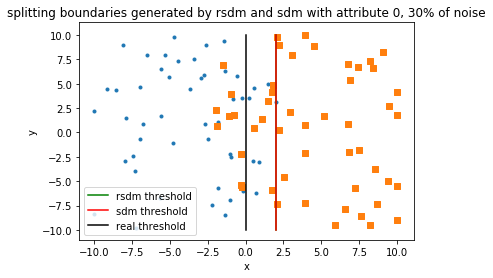

In [263]:
set2_100_30, t = generate_2Ddataset(0, 2, 100, 0.3, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_100_30, 0)
t2, h2 = discretize(sdm, set2_100_30, 0)
display_discretizations_comparison(set2_100_30, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 30% of noise", "rsdm threshold", "sdm threshold")

11


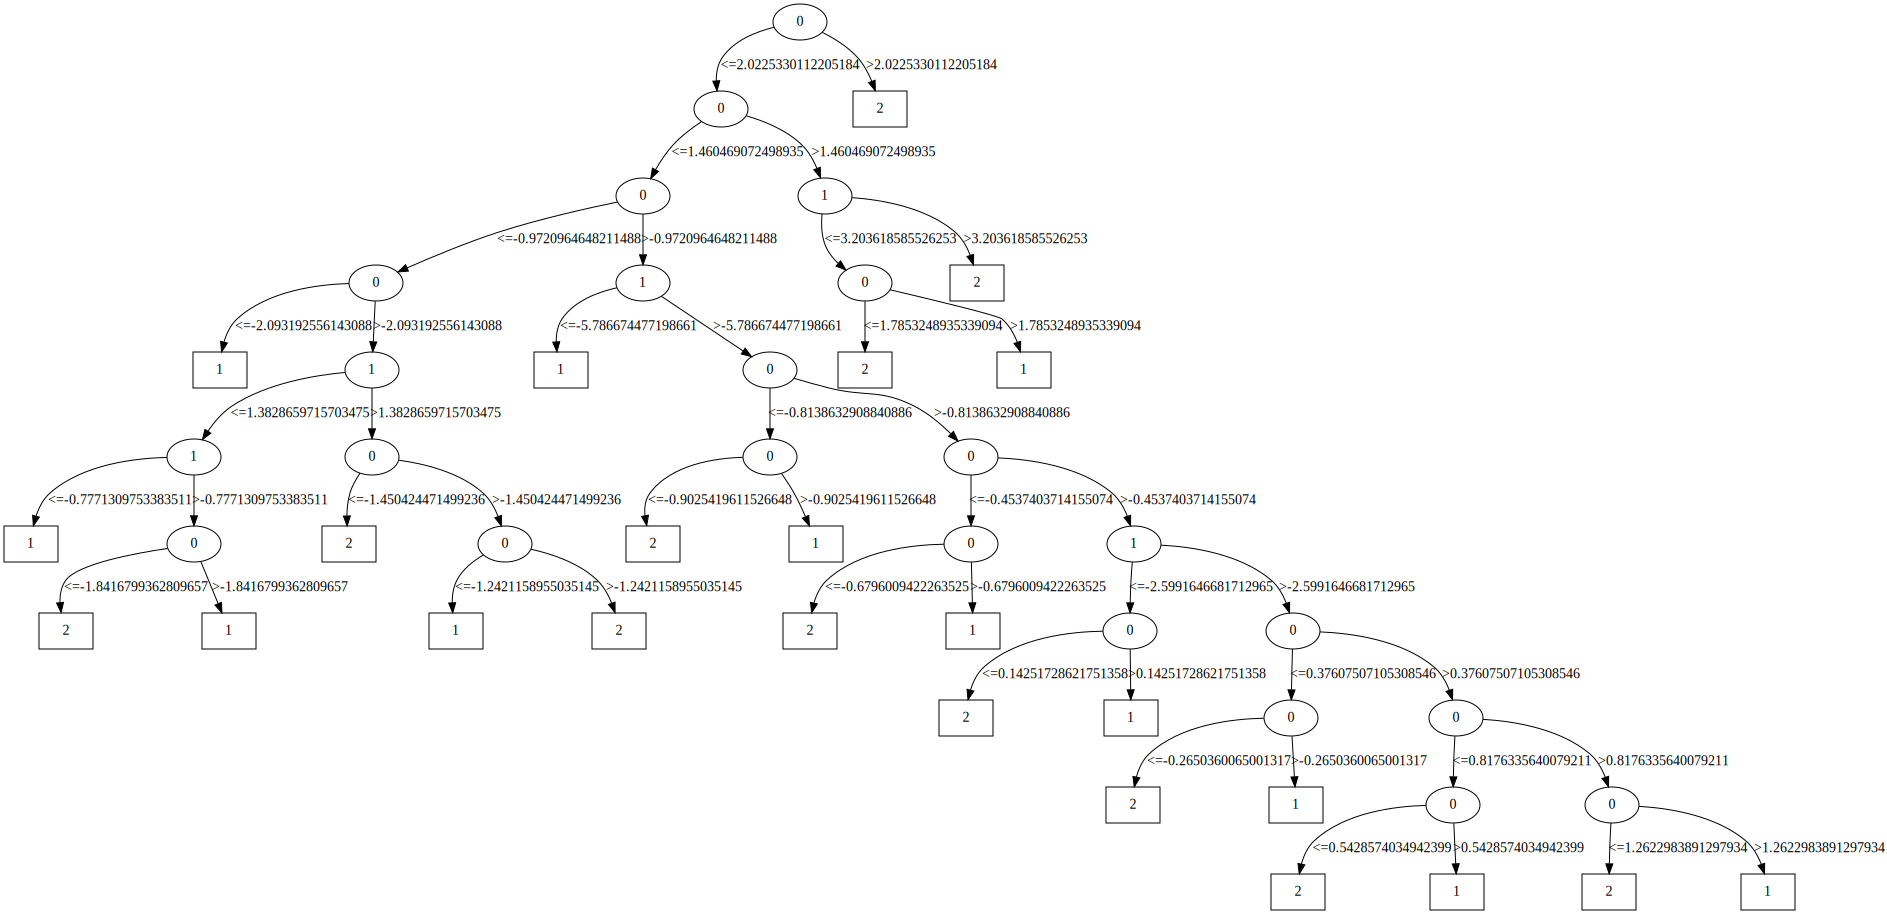

In [264]:
rdmt2_100 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_100.train(set2_100_30)
print(rdmt2_100.root.get_depth())
rdmt2_100.plot()

12


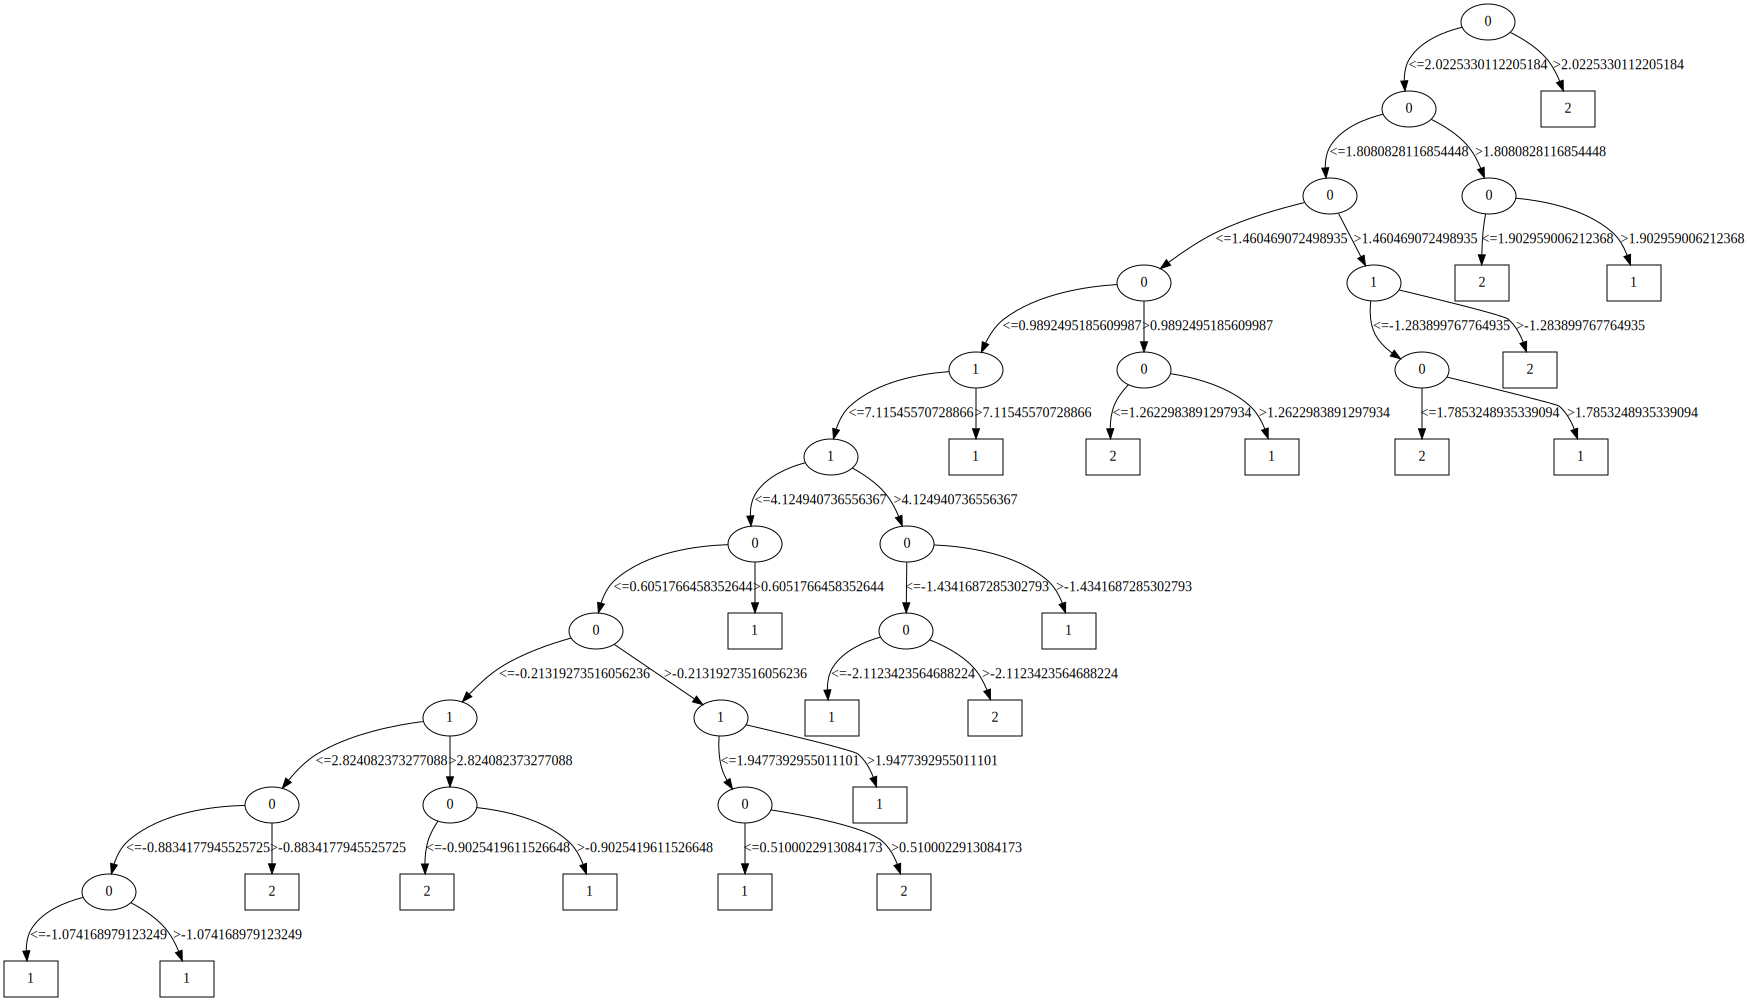

In [265]:
dmt2_100 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_100.train(set2_100_30)
print(dmt2_100.root.get_depth())
dmt2_100.plot()

-> 70% de bruit :

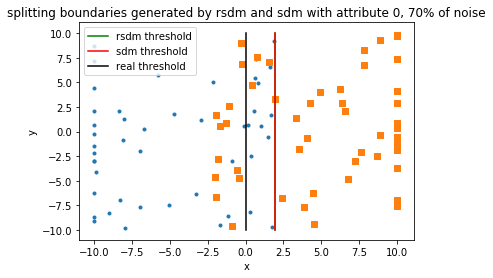

In [266]:
set2_100_70, t = generate_2Ddataset(0, 2, 100, 0.7, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_100_70, 0)
t2, h2 = discretize(sdm, set2_100_70, 0)
display_discretizations_comparison(set2_100_70, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 70% of noise", "rsdm threshold", "sdm threshold")

10


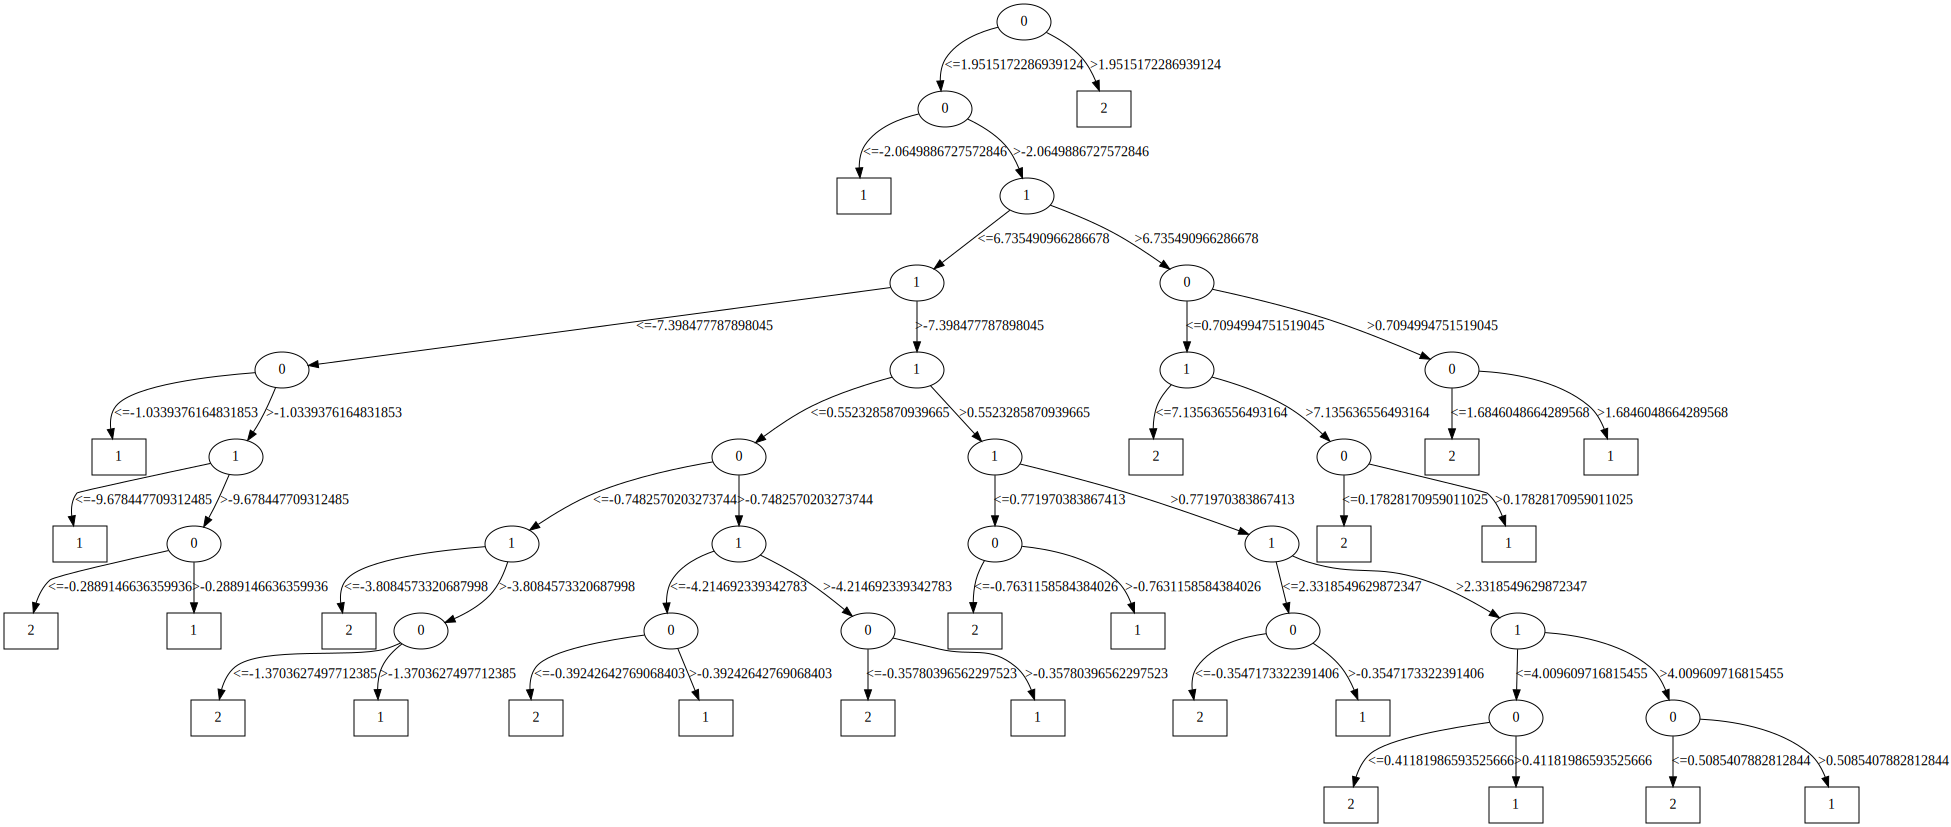

In [267]:
rdmt2_100 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_100.train(set2_100_70)
print(rdmt2_100.root.get_depth())
rdmt2_100.plot()

12


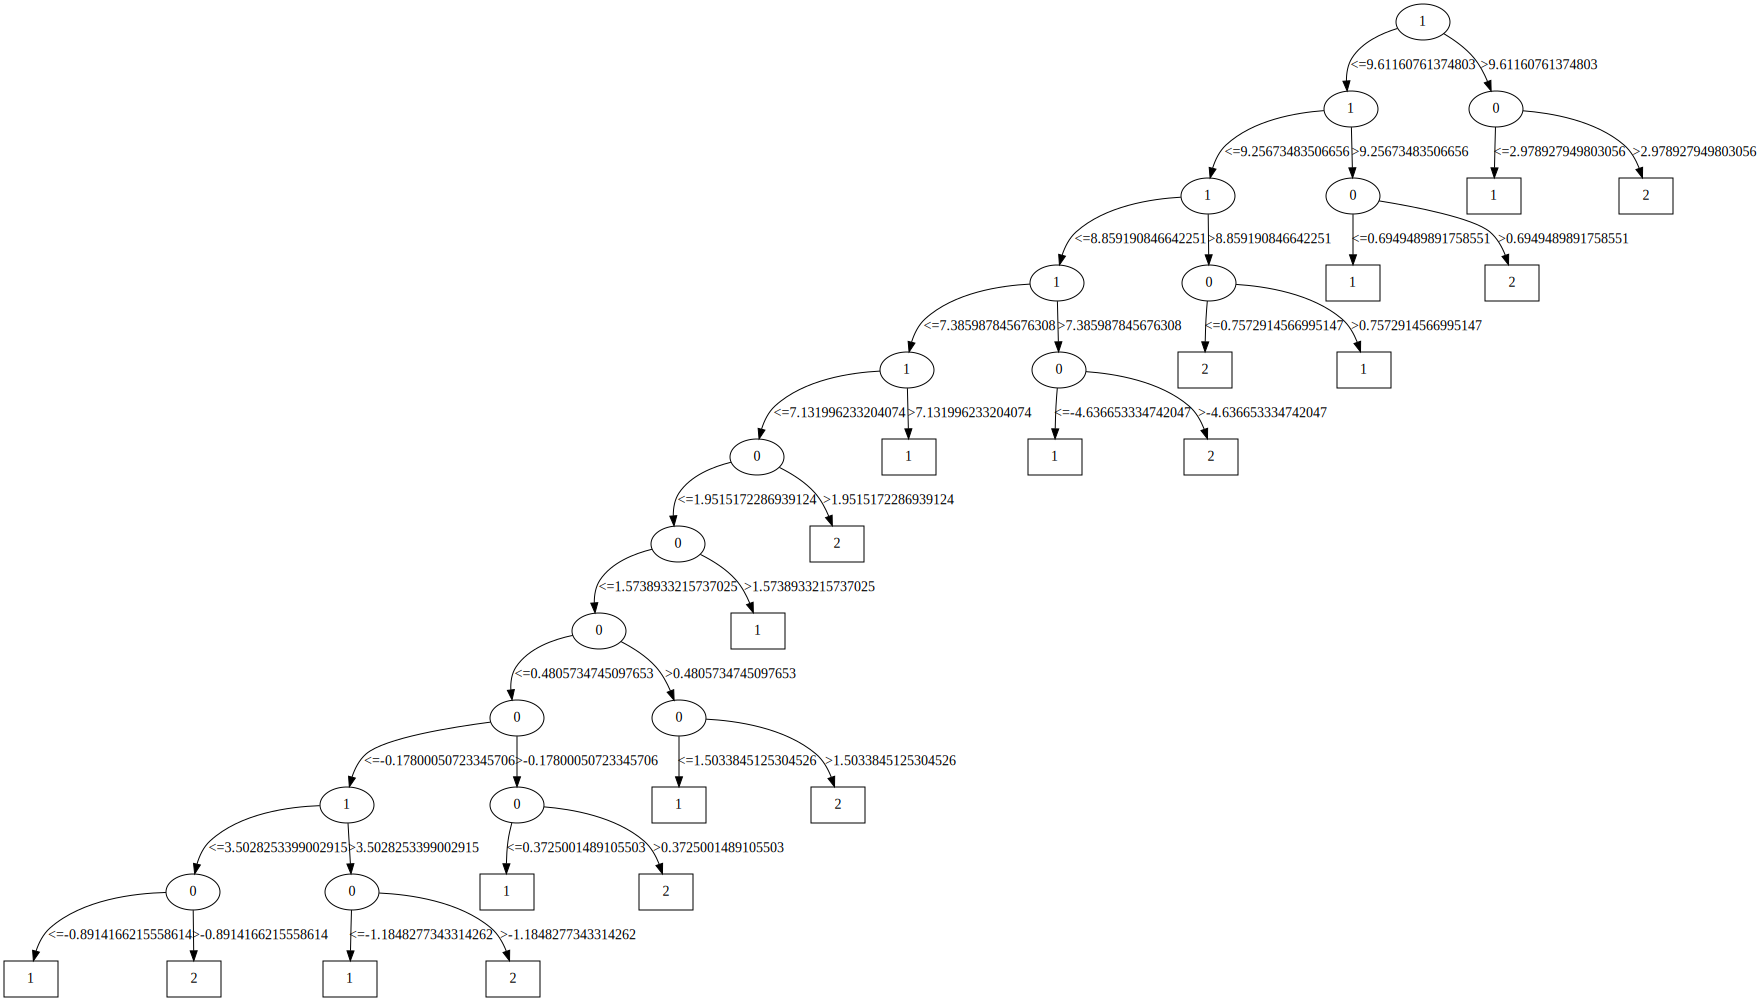

In [268]:
dmt2_100 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_100.train(set2_100_70)
print(dmt2_100.root.get_depth())
dmt2_100.plot()

- 1000 exemples :

-> pas de bruit

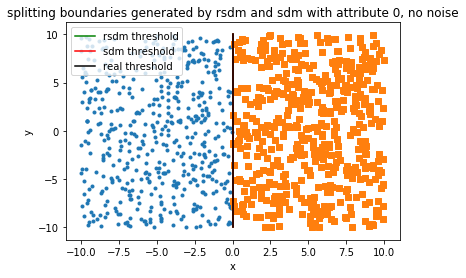

In [294]:
set2_1000_0, t = generate_2Ddataset(0, 2, 1000, 0., 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_1000_0, 0)
t2, h2 = discretize(sdm, set2_1000_0, 0)
display_discretizations_comparison(set2_1000_0, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, no noise", "rsdm threshold", "sdm threshold")

150.9838297367096
2


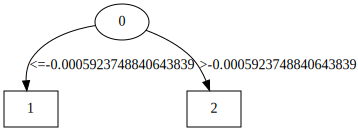

In [297]:
start = time.time()
rdmt2_1000 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_1000.train(set2_1000_0)
print(time.time() - start)
print(rdmt2_1000.root.get_depth())
rdmt2_1000.plot()

2
145.902770280838


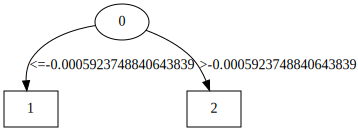

In [298]:
start = time.time()
dmt2_1000 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_1000.train(set2_1000_0)
print(dmt2_1000.root.get_depth())
print(time.time() - start)
dmt2_1000.plot()

-> 30% de bruit :

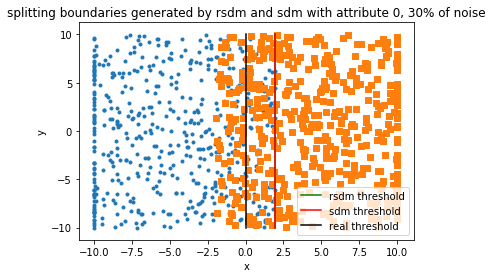

In [299]:
set2_1000_30, t = generate_2Ddataset(0, 2, 1000, 0.3, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_1000_30, 0)
t2, h2 = discretize(sdm, set2_1000_30, 0)
display_discretizations_comparison(set2_1000_30, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 30% of noise", "rsdm threshold", "sdm threshold")

331.51258397102356
12


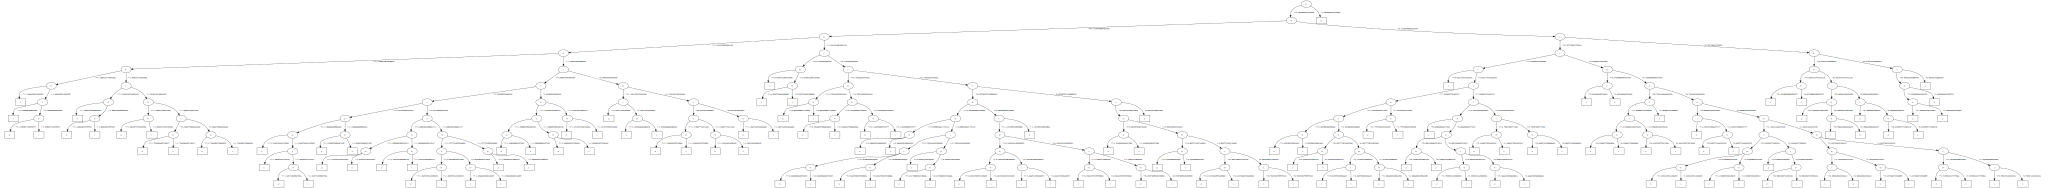

In [300]:
start = time.time()
rdmt2_1000 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_1000.train(set2_1000_30)
print(time.time() - start)
print(rdmt2_1000.root.get_depth())
rdmt2_1000.plot()

12
723.5155968666077


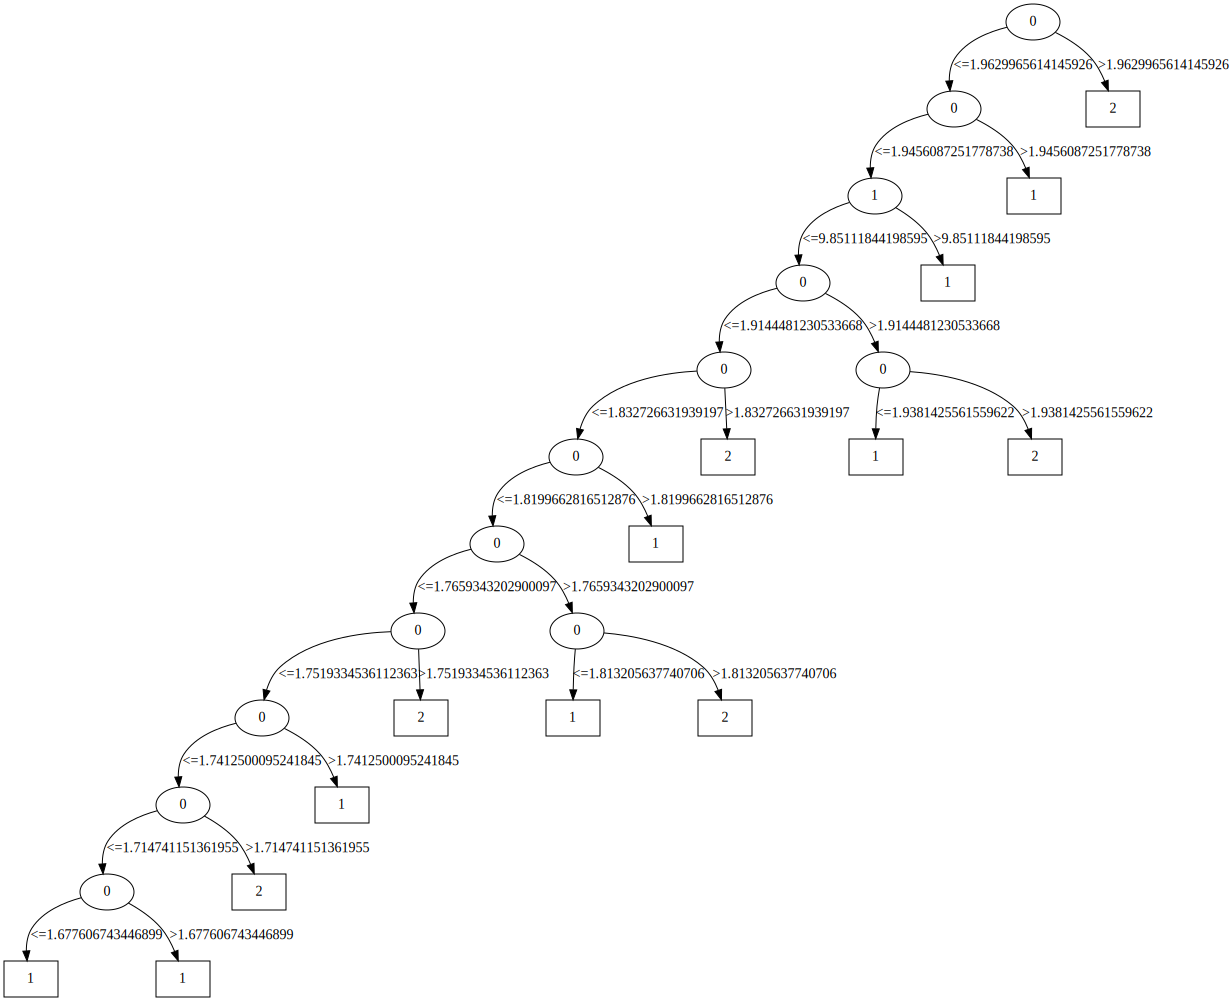

In [301]:
start = time.time()
dmt2_1000 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_1000.train(set2_1000_30)
print(dmt2_1000.root.get_depth())
print(time.time() - start)
dmt2_1000.plot()

-> 70% de bruit :

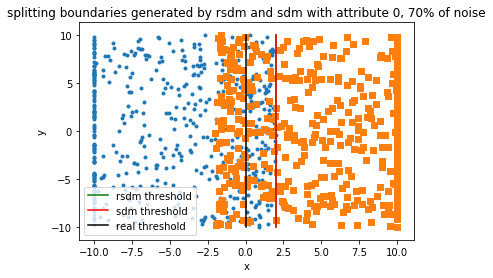

In [302]:
set2_1000_70, t = generate_2Ddataset(0, 2, 1000, 0.7, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_1000_70, 0)
t2, h2 = discretize(sdm, set2_1000_70, 0)
display_discretizations_comparison(set2_1000_70, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 70% of noise", "rsdm threshold", "sdm threshold")

302.7291660308838
12


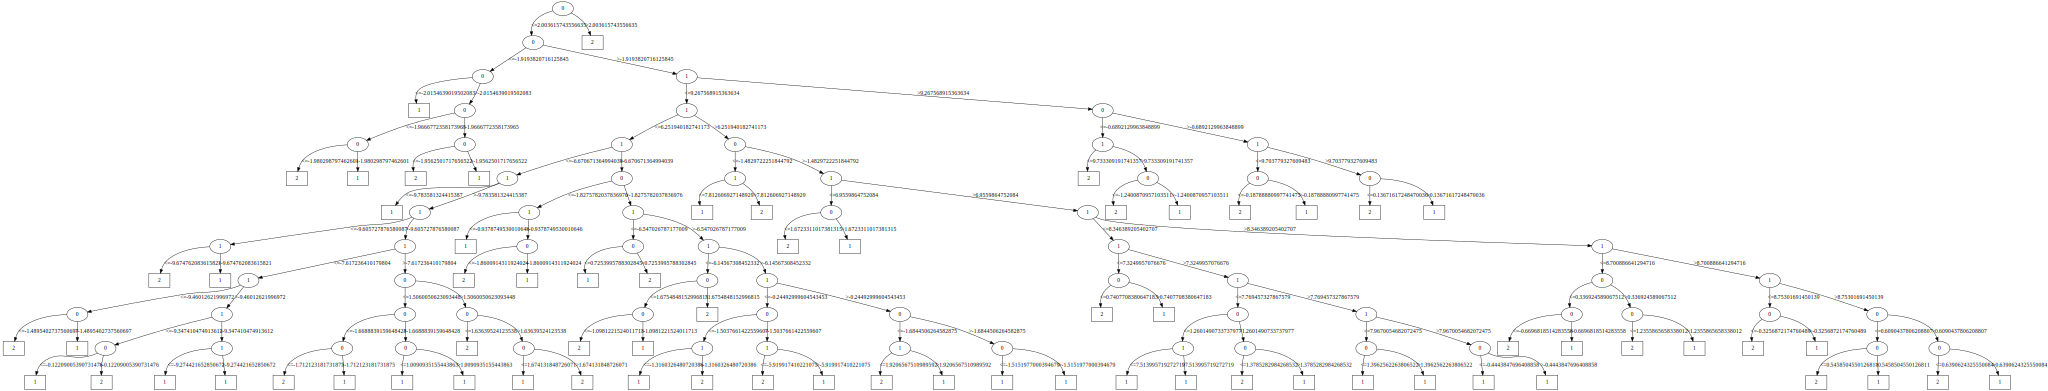

In [304]:
start = time.time()
rdmt2_1000 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_1000.train(set2_1000_70)
print(time.time() - start)
print(rdmt2_1000.root.get_depth())
rdmt2_1000.plot()

868.6346640586853
12


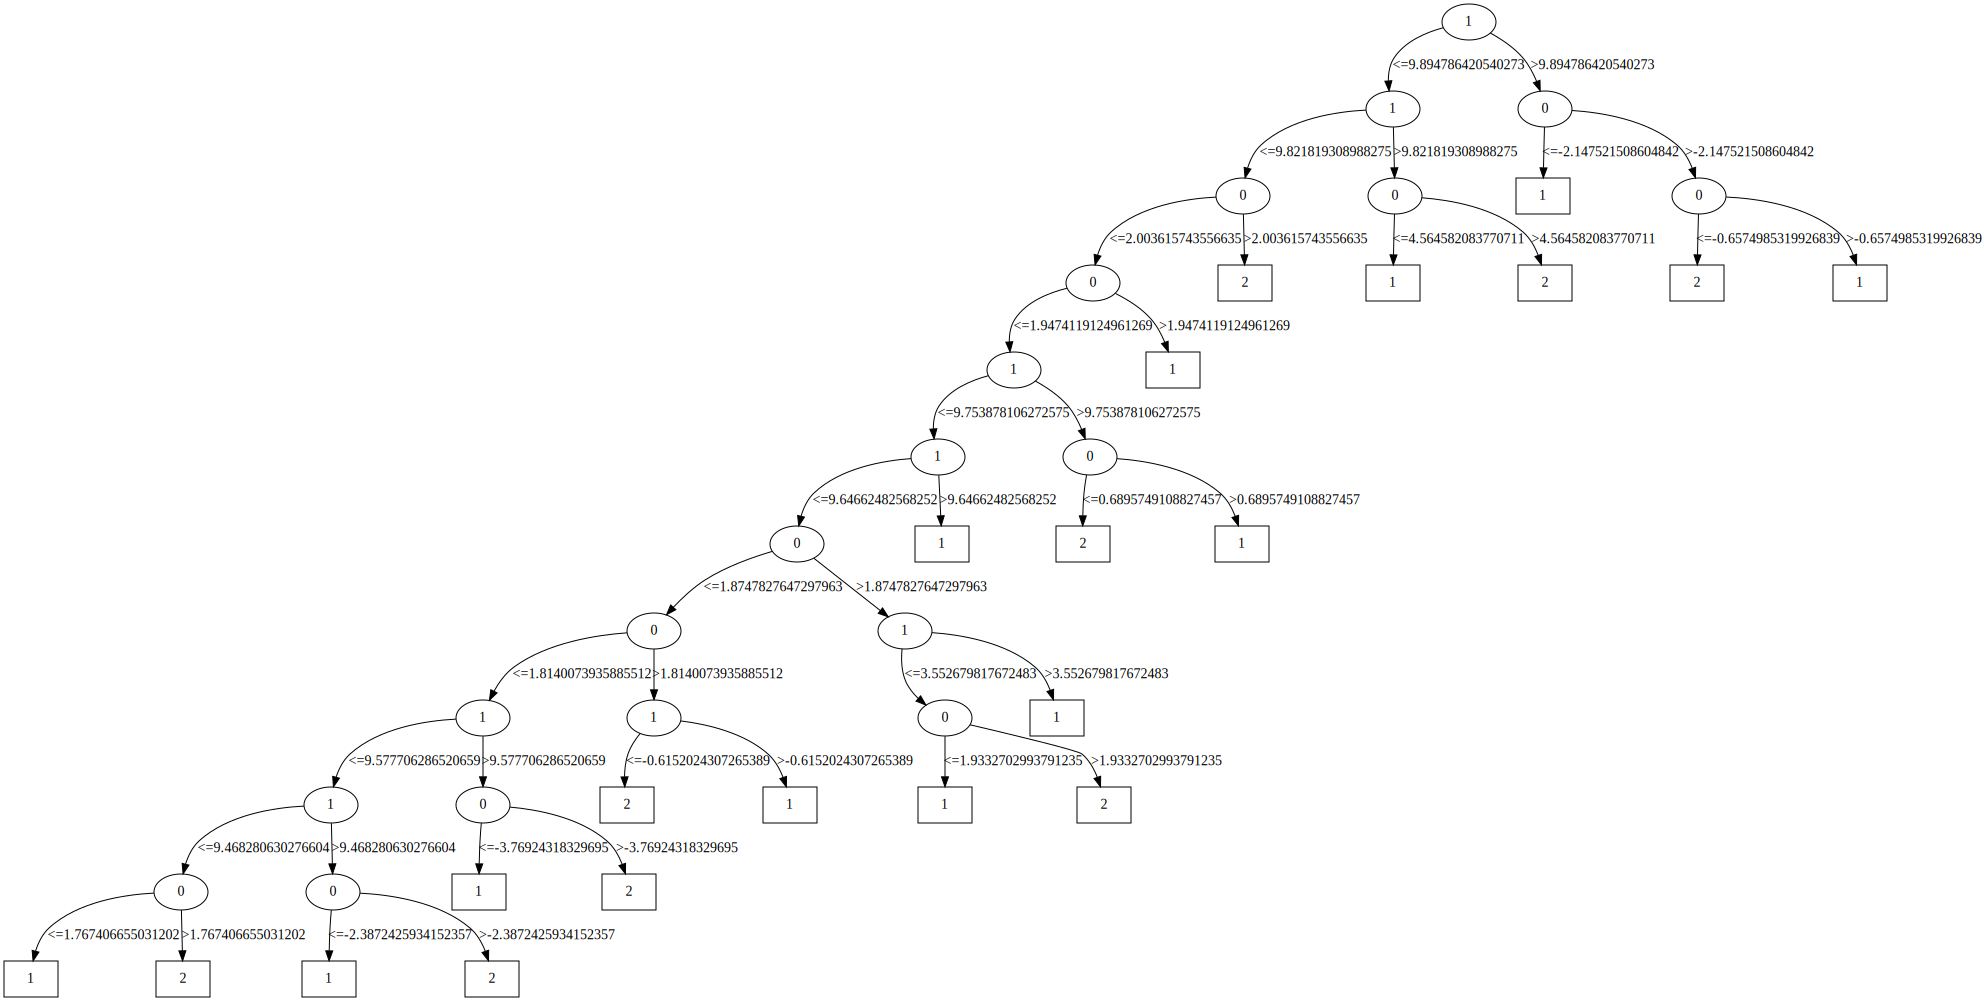

In [303]:
start = time.time()
dmt2_1000 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_1000.train(set2_1000_70)
print(time.time() - start)
print(dmt2_1000.root.get_depth())
dmt2_1000.plot()